In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('airline-passengers.csv',usecols=[1])

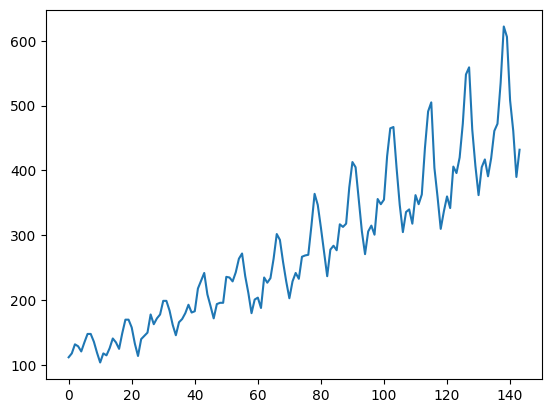

In [2]:
plt.plot(df)
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [5]:
# Converting the previous dataframe to floating point values
dataset = df.values
dataset = dataset.astype('float32')

In [6]:
# LSTM is sensitive to the scale of the input data.
# Rescaling the data to a range of 0-1
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [7]:
# Splitting data into train and test datasets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# Creating a function that create 2 datasets
# X is the number of passengers at any given time
# Y is the number of passengers 1 time step ahead.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# reshaping the data so X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# The LSTM network expects the following input: [samples, time steps, features]
# Currently, the dataset is:  [samples, features]
# Since we are framing the problem with 1 timestep, we'll reshape the data as follows:
trainX = np.reshape(trainX, (
    trainX.shape[0],
    1,
    trainX.shape[1]
))
testX = np.reshape(testX,(
    testX.shape[0],
    1,
    testX.shape[1]
))

# Checking [samples, time steps, features]:
print(np.shape(trainX))
print(np.shape(testX))

(94, 1, 1)
(46, 1, 1)


In [11]:
# creating the network
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 2s 3ms/step - loss: 0.0368
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 11/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 12/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 13/100
94/94 [=================

In [12]:
# making predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 5ms/step


In [13]:
# Inverting predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
#Inverting train and test to check MSE
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])
# Calculating RMSE
# OBS: trainPredict[:,0] gives all the values in column 0 (from all rows)
RMSEtrainScore = np.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
RMSEtestScore = np.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print('Train Score: %.2f RMSE' % (RMSEtrainScore))
print('Test Score: %.2f RMSE' % (RMSEtestScore))

Train Score: 22.67 RMSE
Test Score: 49.21 RMSE


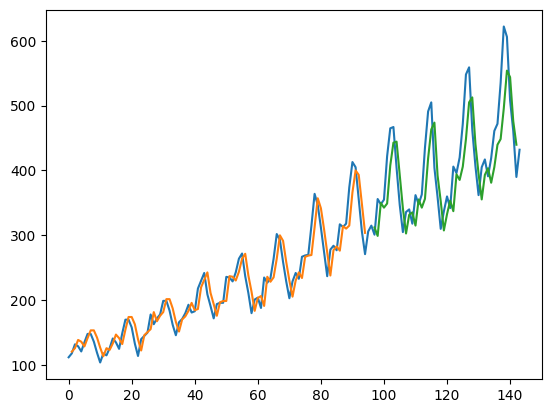

In [14]:
# Because of how the dataset was prepared, the predictions have to be shiffted

# Shifting train predictions:
## creating an array like dataset (144 features)
trainPredictPlot = np.empty_like(dataset)
## filling it with NaN
trainPredictPlot[:,:] = np.nan
## then inserting the train predictions
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict

# Shifting test predictions:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict

# Plotting baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()